In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### 数据制作和加载

In [2]:
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import anndata
import pandas as pd
from pathlib import Path
import numpy as np

class MyDataset(Dataset):
    def __init__(self,mode='train'):
        # import dataset
        data = anndata.read_h5ad(Path("data/laughney20_lung/") / "adata.h5ad") 
        # x1
        self.x1 = data.X
        # x2
        x2 = data.obs.astype('str')
        le = LabelEncoder()
        le_count = 0
        for col in x2:
            if x2[col].dtype == 'object':
                le.fit(x2[col])
                x2[col] = le.transform(x2[col])
                le_count += 1
        self.y = torch.tensor(x2['tier_0_hallmark_corrected'].values, dtype=torch.long)
        x2 = x2.drop('tier_0_hallmark_corrected',axis=1).to_numpy()
        scaler = StandardScaler()
        x2_scaler = scaler.fit_transform(x2)
        self.x2 = x2_scaler
        # split
        np.random.seed(0)
        random_arr = np.random.rand(len(self.y))
        mask = random_arr < 0.8
        if mode == 'train':
            self.x1, self.x2, self.y =  self.x1[mask], self.x2[mask], self.y[mask]
        else:
            mask = random_arr >= 0.8
            self.x1, self.x2, self.y =  self.x1[mask], self.x2[mask], self.y[mask]
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x1 = self.x1[idx].toarray()[0]
        return x1,torch.tensor(self.x2[idx], dtype=torch.float32), self.y[idx]
    
    def get_sample_weights(self):
        class_sample_count = np.unique(self.y, return_counts=True)[1]
        weight = 1. / class_sample_count
        samples_weight = weight[self.y]
        return torch.from_numpy(samples_weight)
train_dataset = MyDataset('train')
test_dataset = MyDataset('test')
samples_weight = train_dataset.get_sample_weights()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(dataset=train_dataset, batch_size=2000, sampler=sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=2000)

In [3]:
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(7,128)
        self.hidden2=nn.Linear(128,256)
        self.hidden3=nn.Linear(256,256)
        self.out=nn.Linear(256,2)
        self.drop=nn.Dropout(0.05)
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=self.drop(x)
        x=F.relu(self.hidden2(x))
        x=self.drop(x)
        x=F.relu(self.hidden3(x))
        x=self.drop(x)
        x=self.out(x)
        return x

In [4]:
# Define the model, loss function, and optimizer
model = MLP() # 定义网络参数
# Move model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
loss_fn = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=0.005) # 优化器 优化MLP模型的


train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 30

# Train the model and evaluate on validation set
for epoch in range(epochs):
    # Train the model on the training set
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (_, x, labels) in enumerate(train_loader):
        # Flatten the image tensors to vectors
        x, labels = x.to(device), labels.to(device)
        # Forward pass
        outputs = model(x)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update training loss and accuracy
        train_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    for _, x, labels in test_loader:
        # Forward pass
        x, labels = x.to(device), labels.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, labels)
        
        # Update validation loss and accuracy
        val_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
    
    # Compute and print the training and validation statistics
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(test_loader.dataset)
    val_acc = val_correct / len(test_loader.dataset)

    TP = torch.sum((labels == 1) & (predicted == 1))
    FP = torch.sum((labels == 0) & (predicted == 1))
    ppv = TP.float() / (TP.float() + FP.float())
    ppv = float(ppv)
    print(ppv)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

cuda
0.0
Epoch [1/30], Train Loss: 0.6880, Train Acc: 0.5867, Val Loss: 0.7038, Val Acc: 0.4325
0.0
Epoch [2/30], Train Loss: 0.6544, Train Acc: 0.7013, Val Loss: 0.7069, Val Acc: 0.4325
0.0
Epoch [3/30], Train Loss: 0.6256, Train Acc: 0.7052, Val Loss: 0.7052, Val Acc: 0.4430
0.0
Epoch [4/30], Train Loss: 0.5984, Train Acc: 0.7129, Val Loss: 0.6995, Val Acc: 0.4430
0.0
Epoch [5/30], Train Loss: 0.5704, Train Acc: 0.7323, Val Loss: 0.6913, Val Acc: 0.4430
0.0
Epoch [6/30], Train Loss: 0.5438, Train Acc: 0.7589, Val Loss: 0.6792, Val Acc: 0.5891
0.0
Epoch [7/30], Train Loss: 0.5156, Train Acc: 0.7984, Val Loss: 0.6644, Val Acc: 0.6774
0.0
Epoch [8/30], Train Loss: 0.4899, Train Acc: 0.8351, Val Loss: 0.6449, Val Acc: 0.7127
0.0
Epoch [9/30], Train Loss: 0.4633, Train Acc: 0.8784, Val Loss: 0.6212, Val Acc: 0.8401
0.0
Epoch [10/30], Train Loss: 0.4378, Train Acc: 0.9160, Val Loss: 0.5955, Val Acc: 0.8724
0.0
Epoch [11/30], Train Loss: 0.4112, Train Acc: 0.9387, Val Loss: 0.5667, Val Acc:

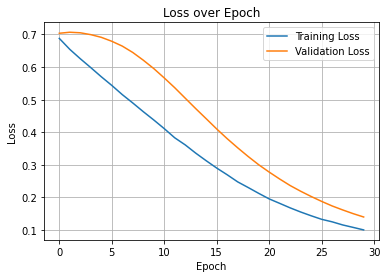

In [5]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss over Epoch')

# 显示图形
plt.show()


### 测试集验证

In [6]:
true_list = []
pred_list = []
prob_list = []
import numpy as np
with torch.no_grad():
    for _,tests, labels in test_loader:
        tests, labels = tests.cuda().float(), labels.cuda().long()
        outputs = model(tests)  # 10,73->10,5
        true = labels.data
        predic = torch.max(outputs.data, 1)[1].cpu()
        prob_list.extend(outputs)
        true_list.extend(true)
        pred_list.extend(predic)
true = np.array([int(x) for x in true_list])
predic = np.array([int(x) for x in pred_list])
probe = np.array([list(x.cpu().data.numpy()) for x in prob_list])

In [7]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
res=pd.DataFrame(metrics.classification_report(true,predic, digits=4,target_names=[0,1],output_dict=True))
res

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,7866.0,206.0,1.0,8072.0,8072.0


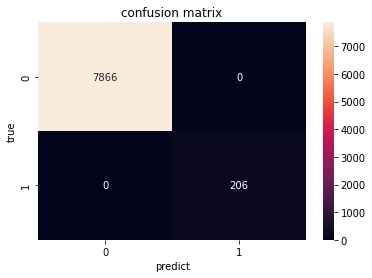

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
def plot_matrix(y_true, y_pred,title_name):
    cm = confusion_matrix(y_true, y_pred)#混淆矩阵
    #annot = True 格上显示数字 ，fmt：显示数字的格式控制
    ax = sn.heatmap(cm,annot=True,fmt='g',xticklabels=['0','1'],yticklabels=['0','1'])
    #xticklabels、yticklabels指定横纵轴标签
    ax.set_title(title_name) #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    return ax
plot=plot_matrix(true,predic,'confusion matrix')
# plt.savefig('Confusion Matrix/CNN.png')
# 混淆矩阵